# Latent Dirichlet allocation

Unfortunately, there are two methods in machine learning with the initials LDA: latent Dirichlet allocation, which is a topic modeling method, and linear discriminant analysis, which is a classification method. The scikit-learn tool has a submodule, sklearn.lda, which implements linear discriminant analysis. At the moment, scikit-learn does not implement latent Dirichlet allocation.

The first topic model that will be looked at is latent Dirichlet allocation. The mathematical ideas behind LDA are fairly complex, and this notebook will not go into the details.

For those who are interested, and adventurous enough, Wikipedia provides all the equations behind these algorithms: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation.

However, the ideas behind LDA intuitively can be understood at a high level. LDA belongs to a class of models that are called generative models as they have a sort of fable explains how the data was generated. In the LDA fable, topics are first created by assigning probability weights to words. Each topic will assign different weights to different words. For example, a Python topic will assign high probability to the word variable and a low probability to the word inebriated. When a new document is wished to be generated, first choose the topics it will use and then mix words from these topics.

For example, there are only three topics that books discuss:
* Machine learning
* Python
* Baking

For each topic, there is a list of words associated with it. This book will be a mixture of the first two topics, perhaps 50 percent each. The mixture does not need to be equal; it can also be a 70/30 split. When the actual text is being generated, it is generated word by word; first decide which topic this word will come from. This is a random decision based on the topic weights. Once a topic is chosen, a word is generated from that topic's list of words. To be precise, a word is chosen in English with the probability given by the topic. The same word can be generated from multiple topics. For example, weight is a common word in both machine learning and baking (albeit with different meanings).

In this model, the order of words does not matter. This is a bag of words model, as it has been already seen in the previous chapter. It is a crude simplification of language, but it often works well enough, because just knowing which words were used in a document and their frequencies is enough to make machine learning decisions.

In the real world, the topics are not known. The task is to take a collection of text and to reverse engineer this fable in order to discover what topics are out there and simultaneously figure out which topics each document uses.

## Building a topic model

Unfortunately, scikit-learn does not implement latent Dirichlet allocation. Therefore, the gensim package from Python is going to be used. Gensim was developed by Radim Řehůřek who is a machine learning researcher and consultant in the United Kingdom.

As input data, a collection of news reports from the Associated Press (AP) is going to be used. After downloading the data, it can be loaded by running the following code:

In [1]:
import os
import urllib.request
import tarfile
import gensim
from gensim import corpora, models

if not os.path.exists("./data"):
    os.mkdir("./data")
    urllib.request.urlretrieve("www.cs.columbia.edu/~blei/lda-c/ap.tgz", "./data/ap.tgz")
    file = tarfile.open('./data/ap.tgz')
    file.extractall('./data')
    file.close()

corpus = corpora.BleiCorpus('./data/ap/ap.dat', './data/ap/vocab.txt')

The corpus variable holds all of the text documents and has loaded them in a format that makes for easy processing. a topic model can be now built, using this object as input:

In [2]:
model = models.ldamodel.LdaModel(corpus, num_topics=100, id2word=corpus.id2word)

This single constructor call will statistically infer which topics are present incorpus. It can be seen the list of topics a document refers to using the model[doc] syntax, as shown in the following example:

In [3]:
doc = corpus.docbyoffset(0)
topics = model[doc]
print(topics)

[(2, 0.020091884), (23, 0.028354883), (24, 0.017303145), (25, 0.019814601), (35, 0.027268237), (40, 0.015105294), (56, 0.011205248), (59, 0.028180523), (74, 0.3203713), (75, 0.075995006), (88, 0.011103514), (90, 0.37194517), (91, 0.037481297), (92, 0.012431928)]


The result will almost surely look different on the computer! The learning algorithm uses some random numbers, and every time a new topic model is learnt on the same input data, the result is different. What is important is that some of the qualitative properties of the model will be stable across different runs if the data is well behaved. For example, if the topics are being used to compare documents, as it is done here, then the similarities should be robust and change only slightly. On the other hand, the order of the different topics will be completely different.

The format of the result is a list of pairs: (topic_index, topic_weight). It can be seen that only a few topics are used for each document (in the preceding example, there is no weight for topics 0, 1, and 3; the weight for those topics is 0). The topic model is a sparse model, as although there are many possible topics, for each document, only a few of them are used. This is not strictly true as all the topics have a non-zero probability in the LDA model, but some of them have such a small probability that it can be rounded to zero as a good approximation.

This can be explored further by plotting a histogram of the number of topics that each document refers to:

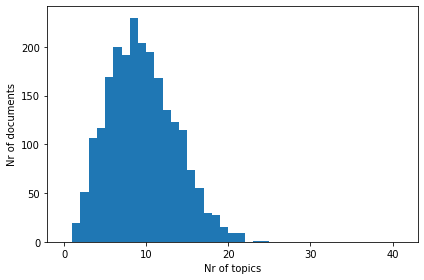

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

num_topics_used = [len(model[doc]) for doc in corpus]
fig,ax = plt.subplots()
ax.hist(num_topics_used, np.arange(42))
ax.set_ylabel('Nr of documents')
ax.set_xlabel('Nr of topics')
fig.tight_layout()
plt.show()

Sparsity means that while there are large matrices and vectors, in principle, most of the values are zero (or so small that they can be rounded to zero as a good approximation). Therefore, only a few things are relevant at any given time.

Often problems that seem too big to solve are actually feasible because the data is sparse. For example, even though any web page can link to any other web page, the graph of links is actually very sparse as each web page will link to a very tiny fraction of all other web pages.

In the preceding graph, it can be seen more or less about the majority of documents deals with around 10 topics.

To a large extent, this is due to the value of the parameters that were used, namely, the alpha parameter. The exact meaning of alpha is a bit abstract, but bigger values for alpha will result in more topics per document.

Alpha needs to be a value greater than zero, but is typically set to a lesser value, usually, less than one. The smaller the value of alpha, the fewer topics each document will be expected to discuss. By default, gensim will set alpha to 1/num_topics, but it can be set explicitly by passing it as an argument in the LdaModel constructor as follows:

In [5]:
model = models.ldamodel.LdaModel(corpus, num_topics=100, id2word=corpus.id2word, alpha=1)

In this case, this is a larger alpha than the default, which should lead to more topics per document. As it can be seen in the combined histogram given next, gensim behaves as it was expected and assigns more topics to each document:

Now, we can see in the preceding histogram that many documents touch upon 20 to 25 different topics. If the value is set lower, the opposite will be shown.

What are these topics? Technically, as it was discussed earlier, they are multinomial distributions over words, which means that they assign a probability to each word in the vocabulary. Words with a high probability are more associated with that topic than words with a lower probability:

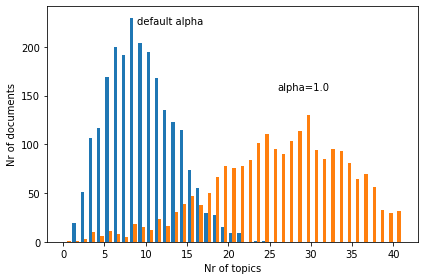

In [6]:
num_topics_used1 = [len(model[doc]) for doc in corpus]

fig, ax = plt.subplots()
ax.hist([num_topics_used, num_topics_used1], np.arange(42))
ax.set_ylabel('Nr of documents')
ax.set_xlabel('Nr of topics')

# The coordinates below were fit by trial and error to look good
ax.text(9, 223, 'default alpha')
ax.text(26, 156, 'alpha=1.0')
fig.tight_layout()
plt.show()

Human brain is not very good at reasoning with probability distributions, but it can readily make sense of a list of words. Therefore, it is typical to summarize topics with a list of the most highly weighted words.

Although daunting at first glance, when reading through the list of words, it can be clearly seen that the topics are not just random words, but instead these are logical groups. The topics can be also represented as a word cloud, making more likely words larger. For example, this is the visualization of a topic that deals with the United States of America:

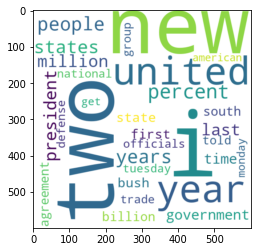

In [7]:
from gensim import matutils
from wordcloud import WordCloud

topics = matutils.corpus2dense(model[corpus], num_terms=model.num_topics)
weight = topics.sum(1)
max_topic = weight.argmax()

words = model.show_topic(max_topic, 64)

wc = WordCloud(background_color='white', max_words=30, width=600, height=600)
wc = wc.generate_from_frequencies(dict(words))

fig,ax = plt.subplots()
ax.imshow(wc, interpolation="bilinear")
plt.show()

It can be also seen that some of the words should perhaps be removed as they are not so informative; they are stop words. It is a good idea also to preprocess the text to stems in order to normalize plurals and verb forms.

## Comparing documents by topic

Topics can be useful on their own to build the sort of small vignettes with words that are shown in the previous screenshot. These visualizations can be used to navigate a large collection of documents. For example, a website can display the different topics as different word clouds, allowing a user to click through to the documents. In fact, they have been used in just this way to analyze large collections of documents.

However, topics are often just an intermediate tool to another end. Now that an estimate for each document of how much of that document comes from each topic is obtained, the documents can be compared in topic space. This simply means that instead of comparing word to word, two documents are similar if they talk about the same topics.

This can be very powerful as two text documents that share few words may actually refer to the same topic! They may just refer to it using different constructions (for example, one document may speak of the United Kingdom while the other will use the abbreviation UK).

Topic models are good on their own to build visualizations and explore data. They are also very useful as an intermediate step in many other tasks.

At this point, the task of finding the most similar post to an input query can be redone, by using the topics to define similarity. Whereas earlier two documents were compared by comparing their word vectors directly, two documents can be now compared by comparing their topic vectors.

For this, the documents are going to be projected to the topic space. That is, the goal is to have a vector of topics that summarizes the document. Here, this notebook shows how topic models can be used for exactly this purpose; once topics have been computed for each document, operations can be performed on the topic vector and forget about the original words. If the topics are meaningful, they will be potentially more informative than the raw words. Additionally, this may bring computational advantages, as it is much faster to compare vectors of topic weights than vectors that are as large as the input vocabulary (which will contain thousands of terms).

In [8]:
topics = matutils.corpus2dense(model[corpus], num_terms=model.num_topics)

Now, topics is a matrix of topics. The pdist function in SciPy can be used to compute all pairwise distances. By default, it uses the Euclidean distance. That is, with a single function call, all the values of sum((topics[ti] - topics[tj])**2) are computed:

In [9]:
from scipy.spatial import distance

distances = distance.squareform(distance.pdist(topics))

Now, one last little trick will be employed; the diagonal elements of the distance matrix will be set to infinity to ensure that it will appear as larger than any other:

In [10]:
for ti in range(len(topics)):
    distances[ti, ti] = np.inf

And it is done! For each document, the closest element can be looked up easily (this is a type of nearest-neighbor classifier):

In [11]:
def closest_to(doc_id):
    return distances[doc_id].argmin()

This will not work if the diagonal elements have not been set to a large value: the function will always return the same element as it is the one most similar to itself (except in the weird case where two elements have exactly the same topic distribution, which is very rare unless they are exactly the same).

If the most similar document to closest_to(1) is asked for, the following document is returned as a result:

In [12]:
closest_to(1)

98

### Modeling the whole of Wikipedia

While the initial LDA implementations can be slow, which limits their use to small document collections, modern algorithms work well with very large collections of data. Following the documentation of gensim, a topic model for the whole of the English-language Wikipedia is going to be built. This takes hours, but can be done with just a laptop! With a cluster of machines, it can go much faster, but that sort of processing environment will be dicussed in a later chapter.

First, the whole Wikipedia dump is downloaded from http://dumps.wikimedia.org. Then, it will be indexed with a gensim tool:

%%python -m gensim.scripts.make_wiki enwiki-latest-pages-articles.xml.bz2 ./wiki_en_output

Run the previous line on the command shell, not on the Python shell! After several hours, the index will be saved in the same directory. At this point, the final topic model can be built. A few packages are first imported:

In [13]:
import logging, gensim

Now, logging is set up using the standard Python logging module (which gensim uses to print out status messages). This step is not strictly necessary, but it is nice to have a little more output to know what is happening:

In [14]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Now the preprocessed data is loaded:

In [15]:
id2word = gensim.corpora.Dictionary.load_from_text('./wiki_en_output_wordids.txt.bz2')
mm = gensim.corpora.MmCorpus('./wiki_en_output_tfidf.mm')

2022-10-16 11:02:29,576 : INFO : loaded corpus index from ./wiki_en_output_tfidf.mm.index
2022-10-16 11:02:29,577 : INFO : initializing cython corpus reader from ./wiki_en_output_tfidf.mm
2022-10-16 11:02:29,578 : INFO : accepted corpus with 5287424 documents, 100000 features, 858666738 non-zero entries


Finally, the LDA model is built as it was done earlier:

In [16]:
model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=100)

2022-10-16 11:02:29,648 : INFO : using symmetric alpha at 0.01
2022-10-16 11:02:29,649 : INFO : using symmetric eta at 0.01
2022-10-16 11:02:29,665 : INFO : using serial LDA version on this node
2022-10-16 11:02:30,426 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 5287424 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2022-10-16 11:02:31,728 : INFO : PROGRESS: pass 0, at document #2000/5287424
2022-10-16 11:02:38,629 : INFO : merging changes from 2000 documents into a model of 5287424 documents
2022-10-16 11:02:39,101 : INFO : topic #33 (0.010): 0.006*"bahamas" + 0.006*"armenia" + 0.006*"alberta" + 0.005*"apollo" + 0.005*"bears" + 0.004*"rail" + 0.004*"bear" + 0.003*"gdp" + 0.003*"saddles" + 0.003*"brooks"
2022-10-16 11:02:39,103 : INFO : topic #84 (0.010): 0.006*"aeschylus" + 0.004*"australian" + 0.004*"space" + 0.004*"alain" 

Once it is done, the topic model can be saved to a file, so it doesn't have to be redone:

In [17]:
model.save('./wiki_lda.pkl')

2022-10-16 14:47:28,801 : INFO : LdaState lifecycle event {'fname_or_handle': './wiki_lda.pkl.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-10-16T14:47:28.801577', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'saving'}
2022-10-16 14:47:28,840 : INFO : saved ./wiki_lda.pkl.state
2022-10-16 14:47:28,889 : INFO : LdaModel lifecycle event {'fname_or_handle': './wiki_lda.pkl', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['state', 'id2word', 'dispatcher'], 'datetime': '2022-10-16T14:47:28.889341', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'saving'}
2022-10-16 14:47:28,890 : INFO : storing np array 'expElogbeta' to ./wiki_lda.pkl.expElogbeta.npy
2022-10-16 14:47:28,912 : INFO : not storing attribute state
2022-

If the session is exited, the model can be loaded again using the following command (after the appropriate imports, naturally):

In [18]:
model = gensim.models.ldamodel.LdaModel.load('wiki_lda.pkl')

2022-10-16 14:48:28,305 : INFO : loading LdaModel object from wiki_lda.pkl
2022-10-16 14:48:28,316 : INFO : loading expElogbeta from wiki_lda.pkl.expElogbeta.npy with mmap=None
2022-10-16 14:48:28,337 : INFO : setting ignored attribute state to None
2022-10-16 14:48:28,338 : INFO : setting ignored attribute id2word to None
2022-10-16 14:48:28,339 : INFO : setting ignored attribute dispatcher to None
2022-10-16 14:48:28,339 : INFO : LdaModel lifecycle event {'fname': 'wiki_lda.pkl', 'datetime': '2022-10-16T14:48:28.339930', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}
2022-10-16 14:48:28,339 : INFO : loading LdaState object from wiki_lda.pkl.state
2022-10-16 14:48:28,359 : INFO : LdaState lifecycle event {'fname': 'wiki_lda.pkl.state', 'datetime': '2022-10-16T14:48:28.359880', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'pla

The model object can be used to explore the collection of documents and build the topics matrix as it was done earlier.

It can be seen that this is still a sparse model even if there are many more documents than earlier (over 5 million as this notebook is being made):

In [19]:
from tqdm import tqdm

if not os.path.exists("./topics.npy"):
    topics = np.zeros((len(mm), model.num_topics))
    for di, doc in enumerate(tqdm(mm)):
        doc_top = model[doc]
        for ti, tv in doc_top:
            topics[di, ti] += tv
    np.save('./topics.npy', topics)
else:
    topics = np.load('./topics.npy', mmap_mode='r')

lens = (topics > 0).sum(axis=1)
print('Mean number of topics mentioned: {0:.4}'.format(np.mean(lens)))
print('Percentage of articles mentioning <10 topics: {0:.1%}'.format(np.mean(lens <= 10)))

Mean number of topics mentioned: 4.208
Percentage of articles mentioning <10 topics: 100.0%


So, the average document mentions 4.208 topics and 100.0 percent of them mention 10 or fewer topics.

It is possible to ask what the most talked about topic on Wikipedia is. This is performed using the following code:

In [20]:
weights = topics.sum(axis=0)
words = model.show_topic(weights.argmax(), 64)

Using the same tools as it was done earlier to build up a visualization, it can be seen that the most talked about topic is related to industrial sectors and is a very coherent topic. Take a look at the following screenshot:

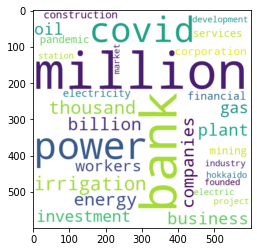

The most mentioned topics is mentioned in 14.1% of documents.
It represents 4.9% of the total number of words.


In [21]:
wc = WordCloud(background_color='white', max_words=30, width=600, height=600)
wc = wc.generate_from_frequencies(dict(words))
fig, ax = plt.subplots()

ax.imshow(wc, interpolation="bilinear")
plt.show()

fraction_mention = np.mean(topics[:, weights.argmax()] > 0)
print("The most mentioned topics is mentioned in {:.1%} of documents.".format(fraction_mention))
total_weight = np.mean(topics[:,weights.argmax()])
print("It represents {:.1%} of the total number of words.".format(total_weight))

Look at the least talked about topic:

In [22]:
words = model.show_topic(weights.argmin(), 64)

Refer to the following screenshot:

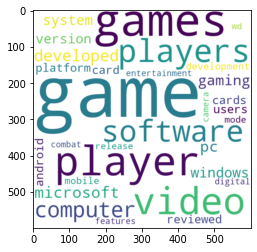

The least mentioned topics is mentioned in 0.4% of documents.
It represents 0.0% of the total number of words.


In [23]:
wc = WordCloud(background_color='white', max_words=30, width=600, height=600)
wc = wc.generate_from_frequencies(dict(words))
fig, ax = plt.subplots()

ax.imshow(wc, interpolation="bilinear")
plt.show()

fraction_mention = np.mean(topics[:,weights.argmin()] > 0)
print("The least mentioned topics is mentioned in {:.1%} of documents.".format(fraction_mention))
total_weight = np.mean(topics[:,weights.argmin()])
print("It represents {:.1%} of the total number of words.".format(total_weight))

The least talked about topic is harder to interpret, but many of its top words refer to locations in Pacific Islands. Just 0.4 percent of documents touch upon it, and it represents just 0.0 percent of the words.

### Choosing the number of topics

So far in the notebook, a fixed number of topics for the analysis has been used, namely 100. Fortunately, for many uses, this number does not really matter. If the topics are going to be only used as an intermediate step, as it was done previously when finding similar posts, the final behavior of the system is rarely very sensitive to the exact number of topics used in the model. This means that as long as topics are used enough, whether it uses 100 topics or 200, the recommendations that result from the process will not be very different. However, 100 is often a good enough number (while 20 is too few for a general collection of text documents), but it could have used more if there were more documents.

The same is true of setting the alpha value. While playing around with it can change the topics, the final results are again robust in terms of this change. Naturally, this depends on the exact nature of the data, and should be tested empirically to make sure that the results are indeed stable.

Topic modeling is often an end toward a goal. A different number of topics or values for parameters such as alpha will result in systems whose end results are almost identical in their final results.

On the other hand, if the topics are going to be explored directly, or a visualization tool that exposes them is built, a few values should be probably tried and see which gives the most useful or most appealing results. There are also statistical concepts such as perplexity that can be used to determine which of a series of models best fits the data, enabling a more informed decision.

Alternatively, there are a few methods that will automatically determine the number of topics, depending on the dataset. One popular model is called the hierarchical Dirichlet
process (HDP). Again, the full mathematical model behind it is complex and beyond the scope of this notebook. However, the important thing is that instead of having the topics fixed first, as in the LDA generative method, the topics themselves are generated along with the data, one at a time. Whenever the writer creates a new document, they have the option of using the topics that already exist or to create a completely new one. When more topics have been created, the probability of creating a new one, instead of reusing what exists, goes down, but the possibility always exists.

This means that the more documents, the more topics it will be ended up with. If there are only a few examples of news articles, then sports will be a topic. However, as there are more, it starts to be breaked up into the individual modalities: hockey, soccer, and so on. As there are even more data, it can start to tell nuances apart, articles about individual teams and even individual players. The same is true for people. In a group of many different backgrounds, with a few computer people, they might be put together; in a slightly larger group, it will have separate gatherings for programmers and systems administrators; and in the real-world, it even has different gatherings for Python and Ruby programmers.

HDP is available in gensim. To adapt the code which was written for LDA, it just need to replace the call to gensim.models.ldamodel.LdaModel with a call to the HdpModel constructor as follows:

In [24]:
hdp = gensim.models.hdpmodel.HdpModel(mm, id2word)

2022-10-16 14:54:29,907 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,361 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,364 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,366 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,369 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,372 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,374 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,376 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,379 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,381 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,384 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,386 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,389 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,391 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,393 : WARNING : likelihood is decreasing!
2022-10-16 14:54:30,396 : WARNING : likelihood is decreasing!
2022-10-

That's it (except that it takes a bit longer to compute—there are no free lunches). Now, this model can be used in much the same way as the LDA model was used, except that the number of topics does not need to be specified.